# AST4310, Autumn 2020, Project 3
### Authored by 15907 & 15909

In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Libraries that is used to analyze the dataset.

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import time as t

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(10, 8)) # Larger figure sizes

Recent observations of the sun have revealed a peculiar phenomenom on its surface. Large dark spots have been detected by the Swedish 1-m Solar Telescope (SST). Observing the Fe I spectral line at 617.334 nm, we observed a region (umbra) with a significant drop in intensity. This umbra spanned approximately 100 Mm at the sun's surface, surrounded by a penumbra stretching almost 100 Mm further out.

Our goal is to extract as much information as possible from the data gained from SST. The data we are looking at is gained from the CRISP instrument in the telescope which produces datasets over a range of wavelengths. The dataset are five dimensional, that is in the x and y direction, a wavelength dimension and also in time and intensity/polarization. In this project we are mostly interested in analyzing the behavior of wavelengths at one frame in intensity. We will also look at the circular polarization (Stokes V) only to determine the magnetic field of the image. The dataset gained from SST is downloaded as a fits file and loaded using Python as the programming language of choise.

Dataset information:
- Location of observation: (x, y) = (-473'', 248'')
- Image resolution: (nx, ny) = (974, 961)
- One pixel width: 1 pixel = 0.058'' = 42.46 km (solar surface)
- Observation date: 7th august 2020
- Cover most of the Fe I 617 nm line
- 13 wavelengths that spans from 617.268 nm to 617.332 nm

In [11]:
data = QTable.read('SST_sunspot_617_2020.08.07.fits')
intensity = data['intensity']
wavelength = data['wavelength']
print("Shape of dataset: ", intensity.shape)
nx = len(intensity[0,0,:])
ny = len(intensity[0,:,0])

Shape of dataset:  (13, 961, 974)


# Radial velocity
An interesting subject would be to investigate the radial velocities of radiation relative to the observerer. We know the true wavelength of a spectral line by observation in a laboratory here on earth. With the observed wavelength from the Sun, we may use these two parameters to calculate the region velocity on the surface of the Sun by introducing Doppler shift formula:

\begin{equation}
    \frac{\Delta \lambda}{\lambda_0} = \frac{v}{c}
    \label{eq:doppler_shift}
\end{equation}
where $\Delta \lambda = \lambda_0 - \lambda$ and $\lambda_0 = 617.300$ nm is the rest wavelength for Fe I while $\lambda$ is the observed wavelength. If we get negative values, we know that the region is moving away from us and vice versa. A plot of the radial velocity is made to visualise the velocity deistribution throughout the field of view as shown below. The dataset is fitted to a Gaussian function.

---$\lambda_0 = 617.300$ er ikke rest wavelength, men det er etter at vi har trukket fra rotasjonshastigheten til sola

------------------ Ha med eller fjerne? ------------------

We know that Earth orbits the Sun in an elliptical path which implies that the Earth and the Sun is moving in an radial direction toward or away from each other. Becuase of this effect, the true velocity of radiation normal to the solar surface does not corresponds with the observation on Earth. If we can calculate the Earth-Sun relative velocity, we may subtract this from the Doppler velocity to obtain a more accurate result of the radiation velocity relative to the Sun itself. Also, we are not looking directly at the disk center but at an inclination relative to the surface normal.

To find the doppler shift along the line of sight, we have to find the wavelength of the line center and insert this in equation \eqref{eq:doppler_shift}. Because we are limited by the resolution in wavelength, it is not immideately clear where the line center is. One way to solve this problem is to Gaussian profile to the spectral lines, and interpretate $\mu$ in the Gaussian as the line center. Fitting a Gaussian to an absorption line presents certain difficulties, namely that an inverted Gaussian is numerically unstable. Therefore we subtract the observed intensity from the continuum intensity at the observed wavelenght. In theory this implies that we treat the spectral lines as emission lines, but for all practical purposes it makes no difference. We fit the gaussian intensity profile 
\begin{equation}
    I(\lambda) = A \exp\left(-\frac{(\lambda-\mu)^2}{2\sigma^2}\right)\,,
    \label{eq:gaussian}
\end{equation}
with the parameters $A, \mu, \sigma$. We interpret $A$ as the strength of the line, $\mu$ as the line center, and $\sigma$ as the width of the line.

In [12]:
#Warning! Although it is not super slow, this cell is still time consuming Runtime: 622.20 s on my laptop.
#To save time, just load gauss_fit.npy (22 Mb). It should be included in the delivery.
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def line_profile():
    gauss_fit = np.zeros((ny, nx, 3))
    p0 = np.array((1e-8, 617.303, 5e-3))
    t0 = t.time()
    for j in range(ny*nx):
        y = j%ny
        x = j//ny
        gauss_fit[y, x],_ = curve_fit(gaussian, wavelength, (intensity[0,y,x] - intensity[:,y,x]), p0=p0)
    print("Processing: Done     Total run time: %.2f s" % (t.time()-t0))
    #The profiles are saved with:
    np.save("gauss_fit.npy", gauss_fit)
#line_profile()
gauss_fit = np.load("gauss_fit.npy")
A = gauss_fit[:,:,0]*units.W/units.Hz/units.m**2/units.sr
mu = gauss_fit[:,:,1]*units.nm
sigma = gauss_fit[:,:,2]*units.nm

After fitting the line profiles, we calculate the doppler velocity relative to our line of sight.

In [13]:
lambda_0=617.300*units.nm
def doppler_shift(wavelength, lambda_0=lambda_0):
    return (lambda_0-wavelength)/lambda_0*constants.c.to('km/s')
v_los = doppler_shift(mu)

Because we look at the sun at an inclination, we only observe the line of sight component of the velocity. To find the velocity perpendicular to the sun's surface we have to calculate
\begin{equation}
    v = \frac{v_{\textrm{los}}}{\cos \theta}\,.
    \label{eq:los}
\end{equation}
We find the angle $\theta$ by the inclination we observe at, and normalize by the angle spanned by the radius of the sun, i.e.
\begin{equation}
    \theta = \frac{\sqrt{\left(\theta_x^\textrm{obs}\right)^2 + \left(\theta_y^\textrm{obs}\right)^2}}{\theta^\textrm{sun}}\,.
\end{equation}

In [14]:
x_angle = -473*units.arcsec
y_angle = 248*units.arcsec
theta_los = np.sqrt(x_angle**2 + y_angle**2)
theta_sun = 948*units.arcsec
theta = (theta_los/theta_sun).value
print("Theta = %.3f" %theta)

Theta = 0.563


Thus, we find the true doppler velocity, and plot it over the region we are looking at.

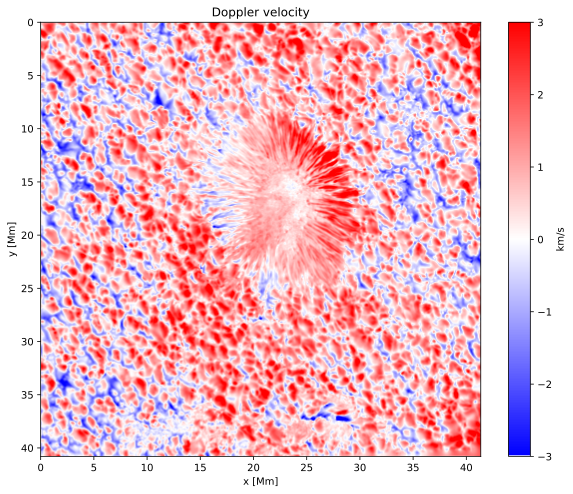

In [15]:
doppler_velocity = v_los/np.cos(theta)
xy_label = [0, 42.46*nx/1000, 42.46*ny/1000, 0]
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(doppler_velocity.value, vmin = -3, vmax = 3, cmap='bwr', extent=xy_label)
ax.set_title("Doppler velocity")
ax.set_xlabel("x [Mm]")
ax.set_ylabel("y [Mm]")
fig.colorbar(im).set_label("km/s");

The velocities in the granulation fluctuates between positive and negative velocities as seen from the figure above which is due to convection. Most of the granulation is moving in a positive direction, i.e. outwards from the surface of the Sun. It turns out that the magnitude of the positive regions is less than the magnitude of the negative regions. The velocity in the umbra is close to zero while the velocity in the penumbra is much greater and only positive. This imply that the velocity in the sunspot is greatest at the penumbra while there is almost no radiation transported to the surface of the Sun in the umbra. Notice that this is true only in the radial direction as we have no information about the horizontal velocity.

# Brightness temperature

Assuming that the Sun radiates as a black body and that we have observed the intensity for Fe I, we are able to calculate the temperature of the Sun known as brightness temperature. This is done by introducing the Planck function:

\begin{equation}
    B_{\nu} (T_{\mathrm{b}}) = I_{\nu}^{\mathrm{obs}}
    \label{eq:planck_function}
\end{equation}
where $B_{\nu}$ is the Planck function, $T_{\mathrm{b}}$ is the brightness temperature and $I_{\nu}^{\mathrm{obs}}$ is the observed intensity of the Fe I spectral line in this case. The Planck function is given as:

\begin{equation}
    B_{\nu}(T_{\mathrm{b}}) = \frac{2h\nu^3}{c^2} \frac{1}{e^{h\nu/k T_{\mathrm{b}}}-1} = I_{\nu}^{\mathrm{obs}}
    \label{eq:planck2}
\end{equation}

We must remember that this Planck function is given in units of [W sr$^{−1}$ m$^{-2}$ Hz$^{-1}$] meaning that we are considering the intensity per unit bandwidth. We know the relation between frequency and wavelength of some spectral line as:

\begin{equation}
    \nu = \frac{c}{\lambda}
\end{equation}
and will therefore use this definition in the Planck function to solve for $T_\mathrm{b}$. The brightness temperature is found by inverting the Planck function:

\begin{equation}
    T_{\mathrm{b}} = \frac{h\nu}{k} \frac{1}{\ln \left( \frac{2h\nu^3}{I_{\nu}^{\mathrm{obs}} c^2} + 1 \right)}
\end{equation}
Most of stellar objects seems do behave similar to a black body but some absorption lines are still present. This include the Fe I 617.3 line which means that we should rather use the continuum wavelength as they are more closely to the effective temperature of the star. The temperature will vary over the full field of view as the intensity varies. The brightness temperature is calculcated using the dataset that we have extracted from the SST in the code cell below.

Max/min temperature: 6710 / 4033 K


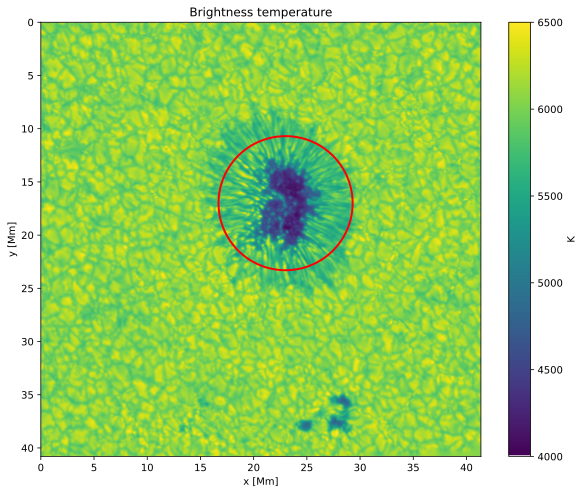

In [16]:
wl_b = wavelength[0]
nu_b = constants.c / wl_b
f1 = constants.h*nu_b / (constants.k_B)
f2 = (2*constants.h*nu_b**3) / (intensity[0,:,:]*constants.c**2)
T_b = (f1/np.log(f2/(units.sr) + 1)).to("K")
print("Max/min temperature: %i / %i K" % (np.max(T_b).value, np.min(T_b).value))

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(T_b.value, cmap='viridis', vmin=4000, vmax=6500, extent=xy_label)
circ = plt.Circle((23,17), 6.3, fill=False, color="red", lw=2)
ax.add_artist(circ)
ax.set_title("Brightness temperature")
ax.set_xlabel("x [Mm]")
ax.set_ylabel("y [Mm]")
fig.colorbar(im).set_label("K");

We observe a relatively big difference in temperature, not only between the dark umbra and the granulation, but also between the umbra and surrounding penumbra. Notice how the temperature between umbra and penumbra are quickly changning. With the assumption that the Sun radiates as a black body, the solar surface temperature lies in the range of 6000-6500 K while the temperature in the umbra is approximately constant at only around 4000 K. This indicates that the temperature fluctuates more in the granulation. Each granule seems to be seperated by darker inter-granular lanes. The plot tells us therefore that the inter-granular lanes is cooler than the granules. The dark pores seen in the bottom of the image are also very cool. These pores do not have a penumbra around the dark regions as the sunspot have. The velocity and the brightening temperature at the pores appeaers not to correlate with each other. We will blink the temperature and velocity plot to see if there are any correlation in the pores between these to parameters.

We remember that we assumed the Sun to radiate as a black body which implies that the intensity of a specific wavelength can be directly related to the temperature from equation (2). Since the temperature is much lower at the umbra, the intensity must also be lower which results in the dark region in the plot.

The plot above also gives an repsesentation of how big the sunspot really is. The red circle is the approximately size of the Earth with an radius of 6.3 Mm. We notice that the entire Earth fits inside the penumbra.

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
x1 = [530,720]
y1 = [800,950]
x2 = [500,700]
y2 = [300,500]

xy_corr1 = [xy_label[1]/nx*x1[0], xy_label[1]/nx*x1[1], xy_label[2]/nx*y1[1], xy_label[2]/nx*y1[0]]
xy_corr2 = [xy_label[1]/nx*x2[0], xy_label[1]/nx*x2[1], xy_label[2]/nx*y2[1], xy_label[2]/nx*y2[0]]

im1 = ax[0].imshow(T_b[y1[0]:y1[1], x1[0]:x1[1]].value, cmap='viridis', vmin=4500, vmax=6500, extent=xy_corr1)
im2 = ax[0].imshow(doppler_velocity[y1[0]:y1[1], x1[0]:x1[1]].value, vmin=-3, vmax=3,  cmap='bwr', extent=xy_corr1)
im3 = ax[1].imshow(T_b[y2[0]:y2[1], x2[0]:x2[1]].value, cmap='viridis', vmin=4500, vmax=6500, extent=xy_corr2)
im4 = ax[1].imshow(doppler_velocity[y2[0]:y2[1], x2[0]:x2[1]].value, vmin=-3, vmax=3,  cmap='bwr', extent=xy_corr2)
fig.colorbar(im1).set_label("K")
fig.colorbar(im2).set_label("km/s")

anim = ArtistAnimation(fig, [[im1, im3], [im2, im4]], interval=1000, blit=True)
fig.tight_layout()
plt.close(fig)
HTML(anim.to_jshtml())

At the left blink plot we have focused at the pores shown at the bottom in the previously plots above. The right blink plot is focused at the right side of the sunspot including both umbra and penumbra. It seems like the velocity is affected mostly in between and not directly at the pores. The velocity right at the pores is close to zero while the velocity between the two rightmost pores seems to be great in both positive and negative direction. There is some disturbance between the cool pores as we see from the left plot. The velocity at the cooler regions is slighty positive but close to zero in both plots. The difference is that the velocity in the penumbra is positive everywhere around the umbra.  

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ims = []
I1 = intensity[:, 200, 200]/intensity[0, 200, 200]
I2 = intensity[:, 400, 550]/intensity[0, 400, 550]
ax[1].plot(wavelength, I1, label='Granulation', color="red")
ax[1].plot(wavelength, I2, label='Umbra', color="blue")

wl = wavelength.value

for i in range(len(wavelength)):
    image1 = ax[0].imshow(data['intensity'][i].value, vmax=4.6e-8, cmap='inferno', extent=xy_label)
    image2, = ax[1].plot(wl[i], I1[i], ".", ms=15, color="red")
    image3, = ax[1].plot(wl[i], I2[i], ".", ms=15, color="blue")
    ax[1].grid(); ax[1].legend()
    ims.append([image1, image2, image3])

anim = ArtistAnimation(fig, ims, interval=500, blit=True)
ax[0].set_xlabel("x [Mm]")
ax[0].set_ylabel("y [Mm]")
fig.tight_layout()
plt.close(fig)
HTML(anim.to_jshtml())

This animation visualise how the intensity of Fe I varies with different wavelengths. The left plot shows the full field of view while the right plot shows the intensity for two arbitrary pixels. One pixel is placed at the granula while the other pixels is placed within the umbra. Notice the difference in change of intensity at the umbra and in the granulation. The intensity is almost constant in the umbra while it has a dip at around $\lambda \approx 617.300$ nm in the granulation.

## Thermal velocity
In stars, the thermal motions of particles are a main factor for broadening of spectral lines. This broadening is known as thermal broadening, and can be found from the standard deviation in the Gaussian profile of the spectral line, i.e.
\begin{equation}
    \frac{v_\textrm{Th}}{c} = \frac{\sigma}{\lambda_0}\,.
\end{equation}
Under the assumption that the only process in charge of the broadening of the spectral lines is the thermal velocities of the iron atoms, we can find the temperature directly from $\sigma$ as 
\begin{equation}
    v_\textrm{Th} = \sqrt{\frac{2kT}{m}} \quad \Leftrightarrow \quad T = \frac{m v_\textrm{Th}^2}{2 k_\textrm{B}}\,.
\end{equation}

9.2732804174277e-26 kg


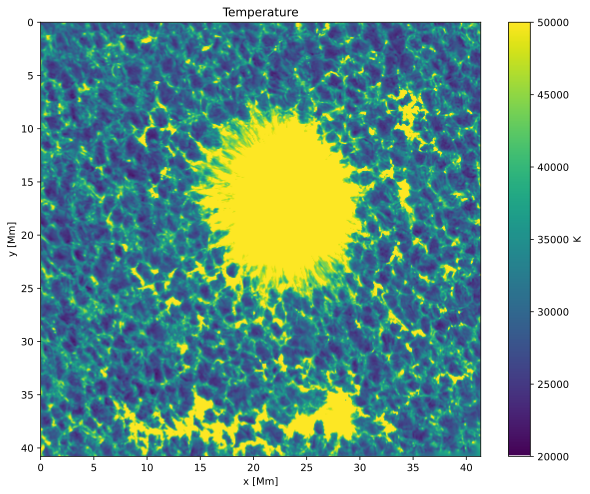

In [22]:
m_Fe = 55.845*units.Dalton
v_Th = sigma/lambda_0*constants.c
T = (m_Fe*v_Th**2/(2*constants.k_B)).to("K")
print(m_Fe.to("kg"))
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(T.value, cmap='viridis', vmin = 20000, vmax = 50000, extent=xy_label)
ax.set_title("Temperature")
ax.set_xlabel("x [Mm]")
ax.set_ylabel("y [Mm]")
fig.colorbar(im).set_label("K");